In [66]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import geopandas as gpd
import geoplot as gplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import os.path
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

# Government of Ontario COVID data 
# Base URL of the public facing website
BASE_URL = "https://data.ontario.ca/dataset"
# Names of datasets, which we can use to fetch CSVs
DATASETS = [
    "Status of COVID-19 cases in Ontario", "Confirmed positive cases of COVID-19 in Ontario"
]

# Local folder to save case data
FOLDER_TEST_DATA = "data"
FOLDER_SHAPEFILES = "shapefiles"

In [2]:
GOVERNMENT_INTERVENTIONS = [
    {
        "date": "2020-03-17", 
        "action": "State of emergency"
    }, 
    #    {
    #    "date": "2020-03-20", 
    #    "action": "US border closed"
    #}, 
        {
        "date": "2020-03-24", 
        "action": "Non-essential\nbusinesses closed"
    }, 
            {
        "date": "2020-04-03", 
        "action": "Non-essential\nbusiness list\nbroadened"
    }, 
]

# Get and clean case data

In [3]:
def get_website_url(dataset_name):
    """
    Return the URL of the public-facing website on COVID from the Government of Ontario.
    
    Parameter
    =========
    dataset_name: str
        The name of the dataset.
        
    Return
    ======
    str
        The URL of the public-facing website to scrape the CSV locations from.
    """
    url_title = dataset_name.lower().replace(" ", "-") 
    url_website = "/".join([BASE_URL, url_title])
    return url_website

In [4]:
def get_data_urls(url_website):
    """
    Return the URLs of test data hosted by the Government of Ontario.
    
    Parameters
    ==========
    url_website: str
        The URL of the public-facing website on COVID from the Government of Ontario.
        
    Return
    ======
    url_test_data: list of str
        List of URLs for CSVs hosted on the site
    """
    response = requests.get(url_website, headers={"User-Agent": "Requests"})
    soup = BeautifulSoup(response.text, "html.parser")
    urls_html = soup.findAll("a", class_="resource-url-analytics btn btn-primary dataset-download-link")
    urls_data = [u["href"] for u in urls_html]
    return urls_data

In [5]:
def fetch_test_data(urls_test_data):
    """
    Get and save today's Ontario COVID data. If it already exists, don't download again.
    
    Parameters
    ==========
    url_test_data: list of str
        URL to the CSV of today's COVID data.
    
    Return
    ======
    filepaths_test_data: list of str
        Local paths to the CSV files containing the COVID data.
    """
    date_iso = pd.to_datetime('now').strftime("%Y-%m-%d")
    date_folder = os.path.join(FOLDER_TEST_DATA, date_iso)
    if not os.path.exists(date_folder):
        os.mkdir(date_folder)
    
    filepaths_test_data = []
    for url in urls_test_data:
        basename_covid_data = os.path.basename(url)
        filename_covid_data = os.path.join(date_folder, basename_covid_data)
        
        if not os.path.exists(filename_covid_data):
            print(f"File doesn't exist: {filename_covid_data}.\nDownloading from {url}.")
            http_response = requests.get(url)
            with open(filename_covid_data, "wb") as f:
                f.write(http_response.content)
        else: 
            print(f"File already exists: {filename_covid_data}. Skipping download.")
        filepaths_test_data.append(filename_covid_data)
    
    return filepaths_test_data

In [6]:
def load_test_data(filename_test_data):
    """
    Load case data into memory.
    
    Parameters
    ==========
    filename_test_data: str
        Path to the CSV files containing the COVID data.
    
    Return
    ======
    tests: DataFrame
        The COVID case count data.
    """
    with open(filename_test_data, "rb") as f:
        tests = pd.read_csv(f)
    return tests

In [7]:
def clean_test_data(tests):
    """
    Clean the case data.
    
    Parameters
    ==========
    tests: DataFrame
        The COVID case count data.
        
    Return
    ======
    tests_cleaned: DataFrame
        The COVID case count data, cleaned.
    """
    df = tests.copy()
    df = df.set_index("Reported Date")
    df.index = pd.to_datetime(df.index)
    df = df.fillna(0)
    df = df.astype(int)
    tests_cleaned = df
    return tests_cleaned

# Download today's data for both datasets

In [8]:
for dataset in DATASETS:
    print(f"Downloading files from the dataset {dataset}")
    url_website = get_website_url(dataset)
    url_dataset = get_data_urls(url_website)
    path_dataset = fetch_test_data(url_dataset)

File doesn't exist: data/2020-04-21/covidtesting.csv.
File doesn't exist: data/2020-04-21/conposcovidloc.csv.
File doesn't exist: data/2020-04-21/conposcovidloc.geojson.


# Investigate Summary dataset: Status of COVID-19 cases

In [9]:
dataset = "Status of COVID-19 cases in Ontario"
url_website = get_website_url(dataset)
url_dataset = get_data_urls(url_website)
path_dataset = fetch_test_data(url_dataset)[0]
case_status = load_test_data(path_dataset)
tests = clean_test_data(case_status)

File already exists: data/2020-04-21/covidtesting.csv. Skipping download.


In [10]:
tests.tail()

,Confirmed Negative,Presumptive Negative,Presumptive Positive,Confirmed Positive,Resolved,Deaths,Total Cases,Total patients approved for testing as of Reporting Date,Total tests completed in the last day,Under Investigation,Number of patients hospitalized with COVID-19,Number of patients in ICU with COVID-19,Number of patients in ICU on a ventilator with COVID-19
Reported Date,,,,,,,,,,,,,
2020-04-16,0,0,0,4344,4194,423,8961,128093,9001,4323,807,248,200
2020-04-17,0,0,0,4491,4556,478,9525,136992,8899,5993,829,245,200
2020-04-18,0,0,0,4621,4875,514,10010,146454,9462,6833,828,250,197
2020-04-19,0,0,0,4816,5209,553,10578,156097,9643,5736,809,247,196
2020-04-20,0,0,0,5085,5515,584,11184,164840,8743,3799,802,247,193


# Plot: fractional change in active cases over time

In [11]:
def add_government_interventions_to_plot(ax, government_interventions):
    """
    Add vertical lines corresponding to government interventions to an axes.
    
    Parameters:
    ===========
    ax: matplotlib axes
        The axes to add the lines to
        
    government_interventions: list of dict
        The interventions to plot. Each list item must have keys:
            date: str, ISO-8601
                The date of the intervention
            action: str
                The text to print to describe the action
                
    Return:
    =======
    The axes with the lines added
    """
    y_pos_initial = 0.35
    y_pos_diff = 0.05
    x_pos_pad = pd.Timedelta(days=0.5)
    
    for n, intervention in enumerate(government_interventions):
        x_pos = pd.to_datetime(intervention["date"])
        y_pos = y_pos_initial - n * y_pos_diff
        
        ax.axvline(
            x_pos, 
            color="salmon", 
            linewidth=3, 
            alpha=0.75)
        
        plt.text(
            x_pos + x_pos_pad, 
            y_pos, 
            intervention["action"], 
            fontsize=12,
            color="tomato",
            transform=ax.get_xaxis_transform()
        )
    return ax

In [12]:
def plot_fractional_change(time_series, start_date, plot_labels={}, government_interventions=[]):
    """
    Plot the fractional change of a metric compared to the previous day. 
    Optionally, add vertical lines for government interventions
    
    Parameters
    ==========
    time_series: Series
        Time series with a datetimeindex
        
    start_date: str, in ISO8601
        The date to start the timeline. 
        
    plot_labels: dict of str
        Descriptions of what the plot means. Both are optional.
            title: str
            subtitle: str
        
    government_interventions: list of dict
        The interventions to plot. Each list item must have keys:
            date: str, ISO-8601
                The date of the intervention
            action: str
                The text to print to describe the action
    Return 
    ======
    fig: matplotlib.figure.Figure
        Contains two Axes: total per day, change per day.
    """
    # Calculate the fractional change, and rolling average
    ts = time_series
    ts = ts/ts.shift(1)
    ts_avg = ts.rolling(7).mean()

    fig, ax = plt.subplots()
    ax.plot(ts, "o",
            color="mediumblue",
            label="Daily change")
    ax.plot(ts_avg, "--", 
            color="cornflowerblue",
            linewidth=3,
            label="Rolling average (7 days)")
    ax.axhline(1, color="mediumseagreen", alpha=0.5, linewidth=3)

    small_font = 12
    medium_font = 16
    large_font = 18

    ax.set_ylim(0.5, 1.5)
    ax.set_xlim(pd.to_datetime([start_date, 'now']))

    # Plot government interventions
    if government_interventions:
        ax = add_government_interventions_to_plot(ax, government_interventions)

    # Add title, and subtitle if it exists
    title = plot_labels.get("title", f"Fraction of {ts.name} compared to the previous day")
    if plot_labels.get("subtitle"):
        fig.suptitle(title, fontsize=large_font, y=0.93)
        ax.set_title(plot_labels["subtitle"], fontsize=small_font, style="italic")
    if not plot_labels.get("subtitle"):
        ax.set_title(title, fontsize=large_font)
    
    ax.set_ylabel("Fraction", rotation=0, labelpad=60, fontsize=medium_font)
    ax.set_xlabel("Date", fontsize=medium_font)
    ax.tick_params(labelsize=small_font)
    ax.legend(fontsize=medium_font, fancybox=True)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %-d"))
    ax.xaxis.set_major_locator(mdates.DayLocator([1,15]))
    ax.xaxis.grid(True, which="major")

    fig.autofmt_xdate()
    plt.show()

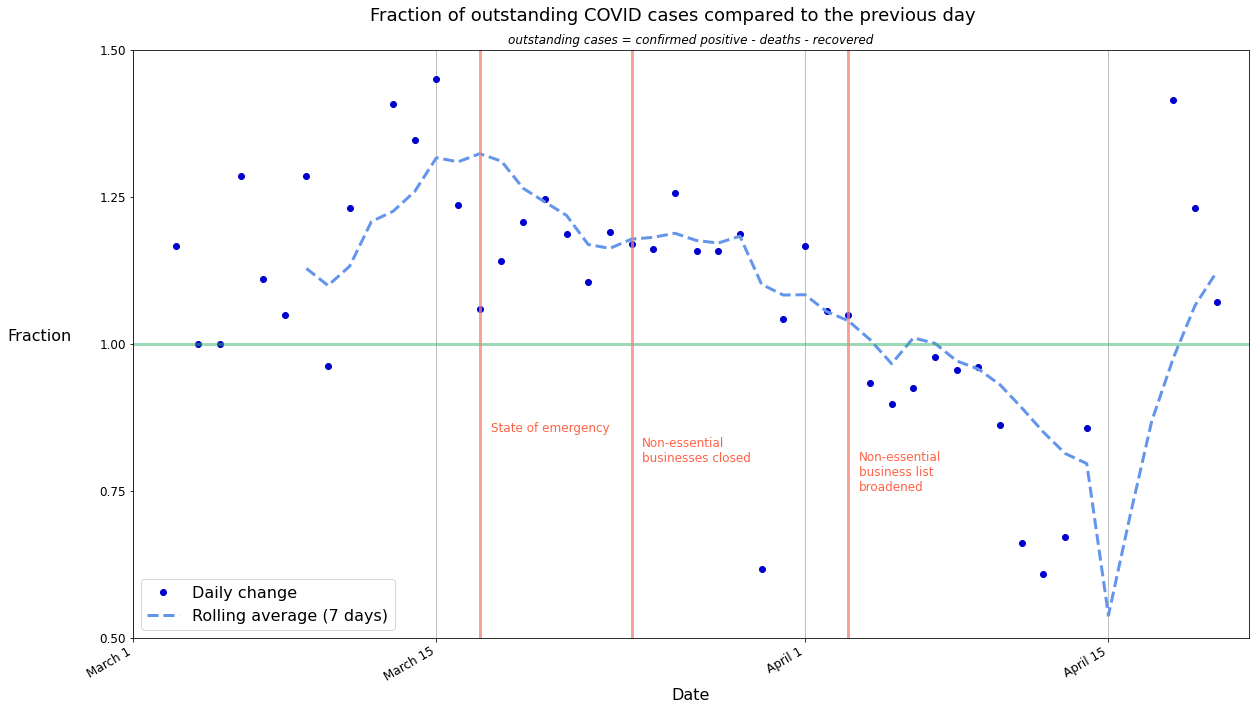

In [13]:
# Outstanding cases are confirmed positives that have not ended in: deaths, resolved
time_series = tests["Confirmed Positive"] - tests["Deaths"] - tests["Resolved"]
start_date = "2020-03-01"
plot_labels = {
    "title": "Fraction of outstanding COVID cases compared to the previous day",
    "subtitle": "outstanding cases = confirmed positive - deaths - recovered"
}

plot_fractional_change(time_series, start_date, plot_labels=plot_labels, government_interventions=GOVERNMENT_INTERVENTIONS)

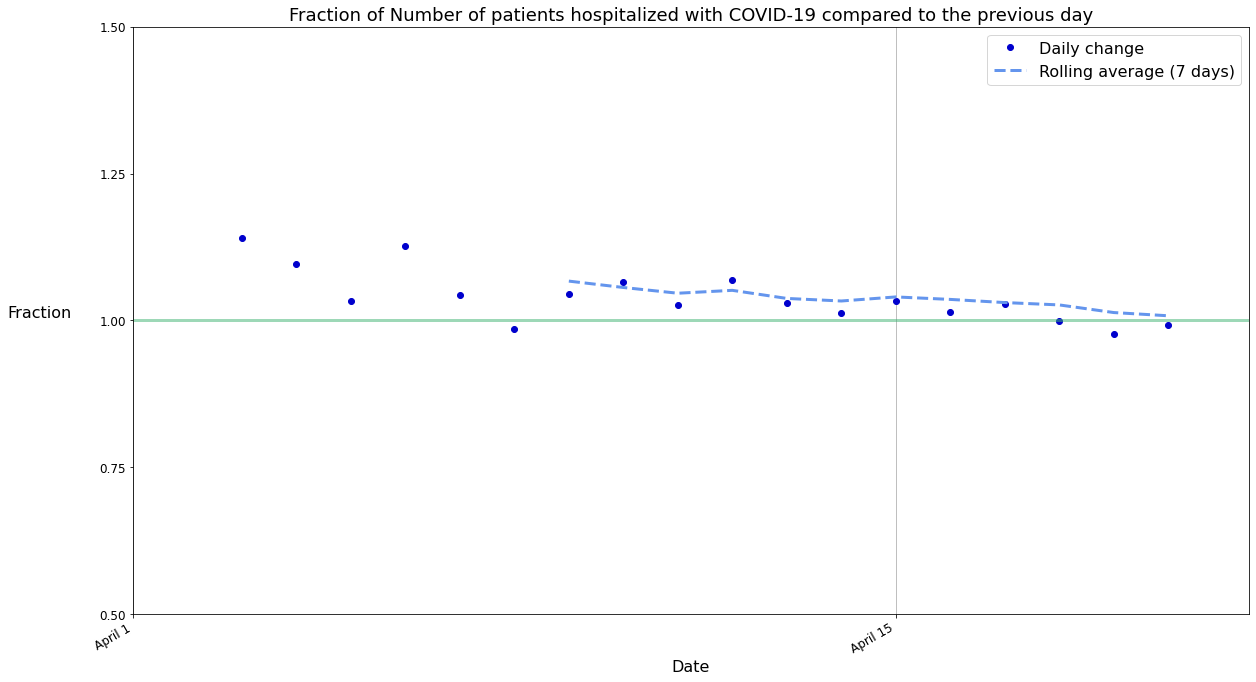

In [14]:
# Outstanding cases are confirmed positives that have not ended in: deaths, resolved
time_series = tests["Number of patients hospitalized with COVID-19"]
start_date = "2020-04-01"
plot_fractional_change(time_series, start_date)

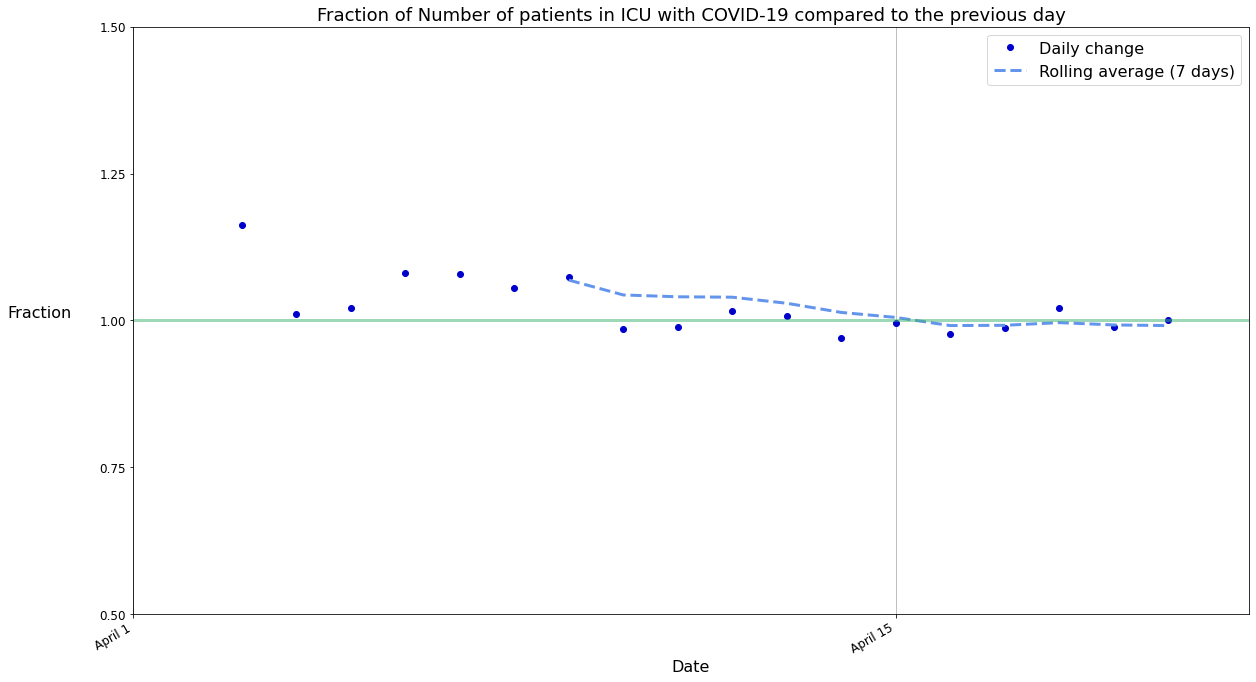

In [15]:
time_series = tests["Number of patients in ICU with COVID-19"]
start_date = "2020-04-01"
plot_fractional_change(time_series, start_date)

# Plot case count timeseries

In [74]:
def plot_timeline(time_series, start_date):
    """
    Make a pretty plot of a timeseries.
    
    Parameters
    ==========
    time_series: DataFrame
        Table with a datetimeindex
        
    start_date: str, in ISO8601
        The date to start the timeline. 
        
    Return 
    ======
    fig: matplotlib.figure.Figure
        Contains two Axes: total per day, change per day.
    """
    fig, [ax_total, ax_change] = plt.subplots(nrows=2, ncols=1)
    axes = {"total": ax_total, "change": ax_change}
    text = {
        "total": {
            "title": "Running total per day", 
            "ylabel": "# Cases", "xlabel": "Date"
        },
        "change": {
            "title": "Change per day", 
            "ylabel": "# Cases", "xlabel": "Date"
        }
    }
        
    time_series.index = pd.to_datetime(time_series.index)
    ts = {"total": time_series, "change": time_series - time_series.shift(1)}
    
    # Iterate over the two kinds of graph: total, and change
    for name, ax in axes.items():          
        # Restrict range in x-axis
        x_data_max = pd.to_datetime(start_date)
        if name == "change":
            x_data_max = x_data_max + pd.DateOffset(1)

        df = ts[name]
        df_plot = df[df.index >= x_data_max]
        
        colors = cm.Dark2(np.linspace(0, 1, len(df_plot.columns)))
        bar_below = pd.Series(data=0, index=df_plot.index)
        # Iterate over the columns selected
        for col, c in zip(df_plot, colors):
            if name == "total":
                ax.bar(
                    x=df_plot.index,
                    height=df_plot[col],
                    label=col,
                    color=c,
                    bottom=bar_below
                )
                bar_below = bar_below + df_plot[col]
            if name == "change":
                ax.plot(
                    df_plot[col], 
                    linewidth=0,
                    marker="o",
                    markersize="7",
                    alpha=0.75,
                    # label=col,
                    color=c
                )
                ax.plot(
                    df_plot[col].rolling(7).mean(), 
                    linewidth="3",
                    linestyle="-",
                    markersize="0",
                    alpha=1,
                    label=f"{col} average",
                    color=c
                )
                ax.axhline(
                    0, 
                    linewidth="2",
                    color="grey"
                )
        
        ax.set_xlim([pd.to_datetime(start_date), ts[name].index.max() + pd.DateOffset(1)])
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %-d"))
        ax.xaxis.grid(True, which="major")

        ax.set_title(text[name]["title"])
        ax.legend()

    fig.autofmt_xdate()
    return fig

## Morbid measures

In [51]:
morbid_cols = {
    "Number of patients hospitalized with COVID-19": "hospital",
    "Number of patients in ICU with COVID-19": "icu",
    "Number of patients in ICU on a ventilator with COVID-19": "ventilator",
    "Deaths": "deaths"
}
morbid = tests[morbid_cols].rename(columns=morbid_cols)

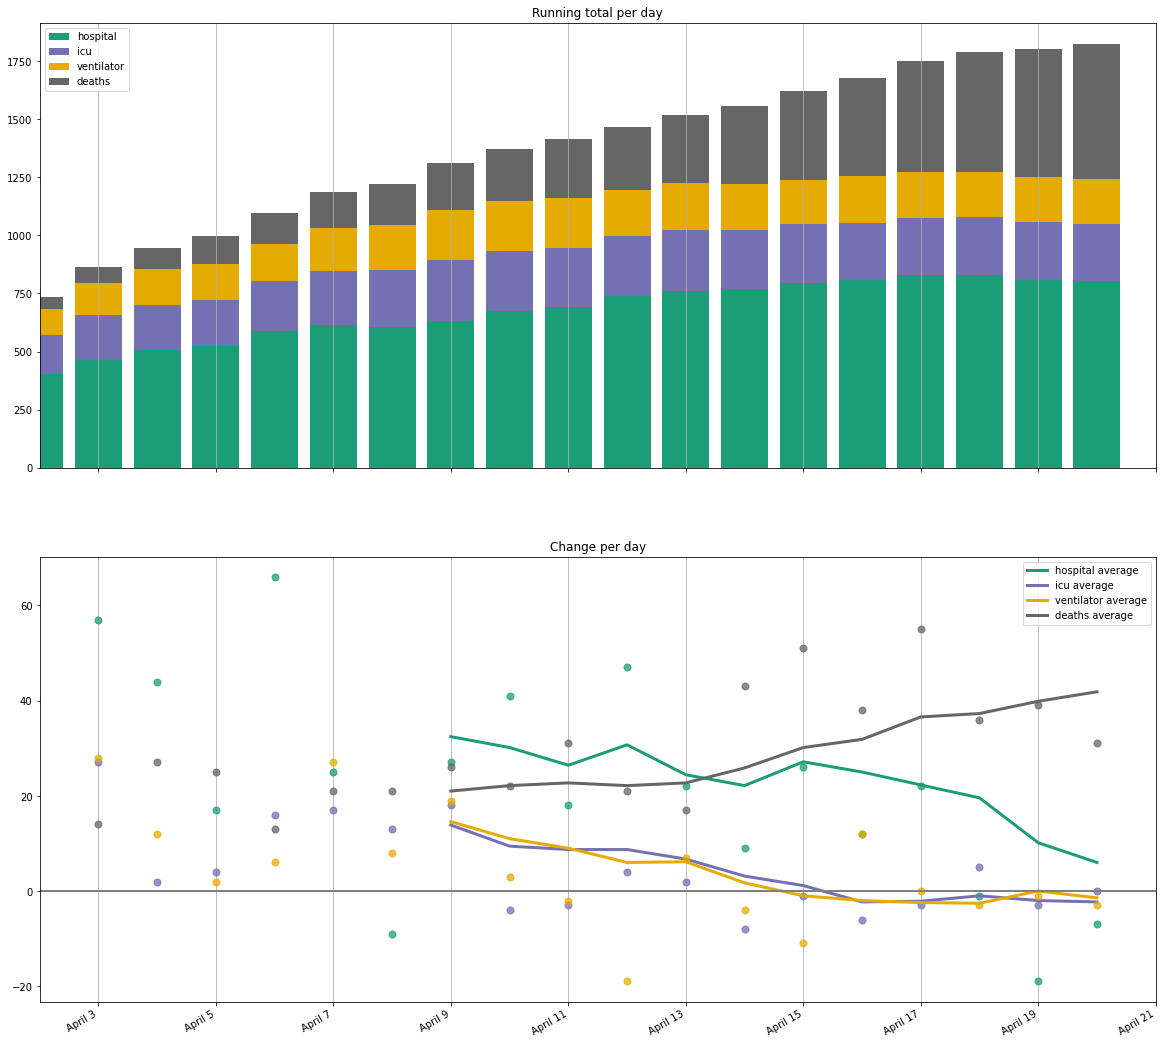

In [75]:
fig = plot_timeline(morbid, "2020-04-02")
plt.show()

## Total cases

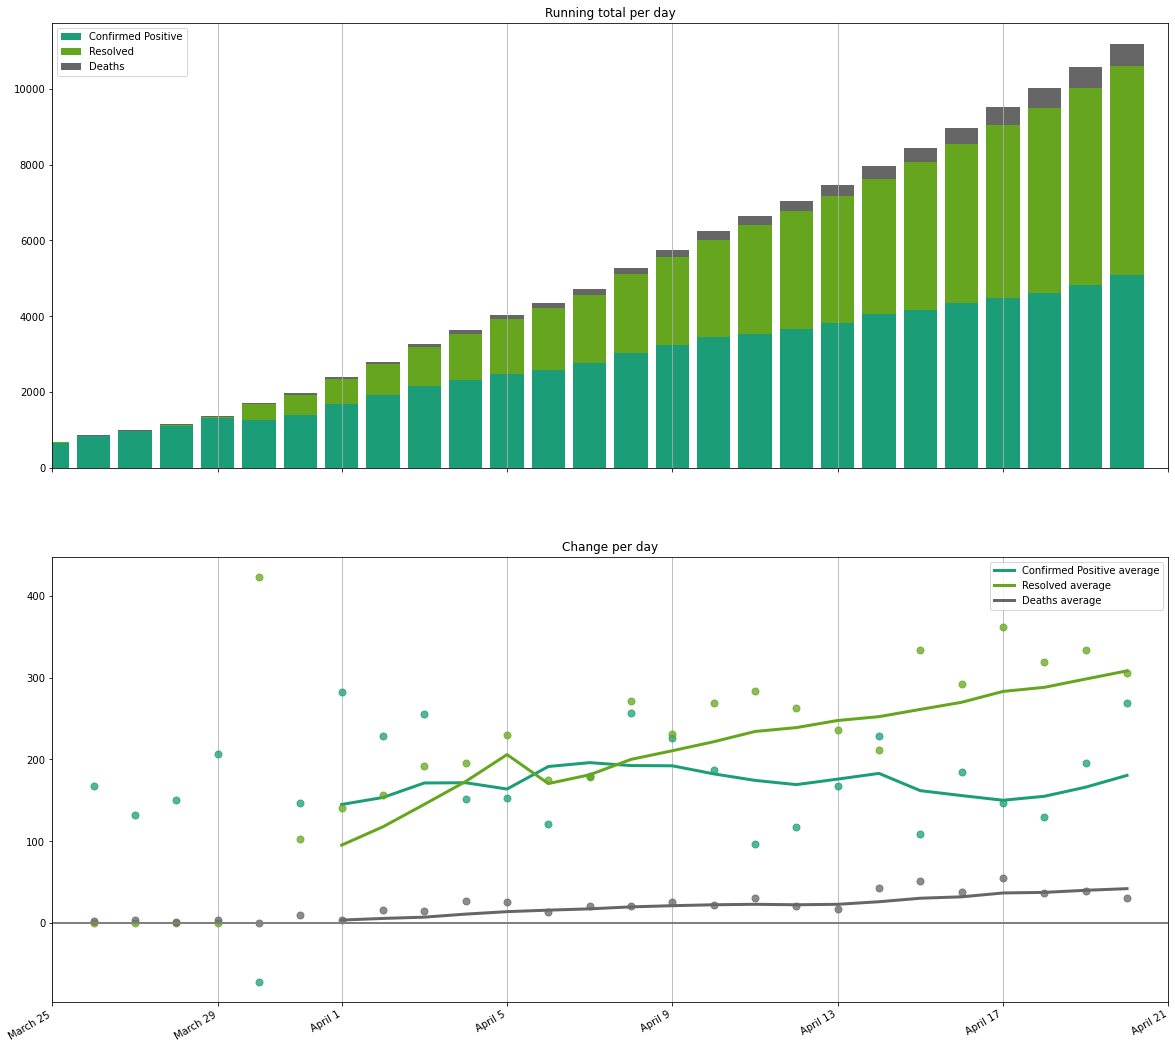

In [76]:
case_cols = ["Confirmed Positive", "Resolved", "Deaths"]
cases = tests[case_cols]
fig = plot_timeline(cases, "2020-03-25")
plt.show()

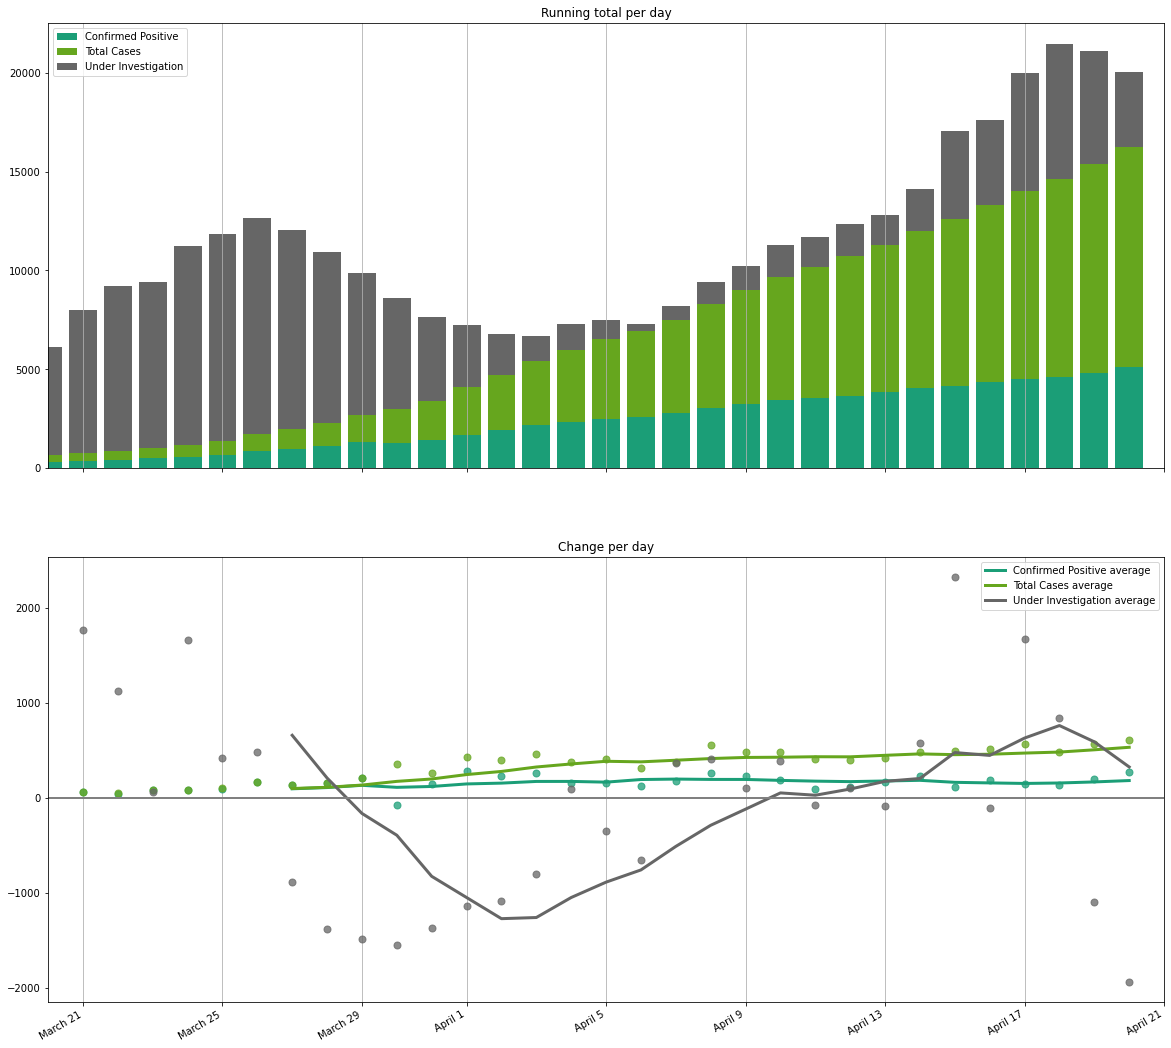

In [77]:
case_cols = ["Confirmed Positive", "Total Cases", "Under Investigation"]
cases = tests[case_cols]
fig = plot_timeline(cases, "2020-03-20")
plt.show()

# Investigate Detailed dataset: Confirmed positive COVID-19 cases in Ontario

In [78]:
dataset = "Confirmed positive cases of COVID-19 in Ontario"
url_website = get_website_url(dataset)
url_dataset = get_data_urls(url_website)
paths_dataset = fetch_test_data(url_dataset)

File already exists: data/2020-04-21/conposcovidloc.csv. Skipping download.
File already exists: data/2020-04-21/conposcovidloc.geojson. Skipping download.


Load the first file: tabular data from a CSV

In [79]:
pos_csv = load_test_data(paths_dataset[0])

In [80]:
pos_csv.tail()

,ROW_ID,ACCURATE_EPISODE_DATE,Age_Group,CLIENT_GENDER,CASE_ACQUISITIONINFO,OUTCOME1,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
11179,11180,2020-04-15,70s,MALE,Information pending,Not Resolved,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
11180,11181,2020-04-15,30s,MALE,Information pending,Not Resolved,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
11181,11182,2020-04-16,40s,FEMALE,Information pending,Not Resolved,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
11182,11183,2020-04-10,50s,FEMALE,Information pending,Not Resolved,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
11183,11184,2020-04-15,60s,MALE,Information pending,Not Resolved,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358


In [83]:
pos_csv.columns

Index(['ROW_ID', 'ACCURATE_EPISODE_DATE', 'Age_Group', 'CLIENT_GENDER',
       'CASE_ACQUISITIONINFO', 'OUTCOME1', 'Reporting_PHU',
       'Reporting_PHU_Address', 'Reporting_PHU_City',
       'Reporting_PHU_Postal_Code', 'Reporting_PHU_Website',
       'Reporting_PHU_Latitude', 'Reporting_PHU_Longitude'],
      dtype='object')

Load the second file: geographic data from the geoJSON

In [84]:
filename_geojson = paths_dataset[1]
with open(filename_geojson, "rb") as f:
    pos_geo = gpd.read_file(f)

In [85]:
pos_geo.tail()

,CASE_ACQUISITIONINFO,Reporting_PHU_Postal_Code,CLIENT_GENDER,OBJECTID,ACCURATE_EPISODE_DATE,OUTCOME1,Reporting_PHU_City,Reporting_PHU_Latitude,Reporting_PHU_Website,ROW_ID,_id,Age_Group,Reporting_PHU_Address,Reporting_PHU_Longitude,Reporting_PHU,geometry
11179,Information pending,M5B 1W2,MALE,11180,2020-04-15T00:00:00,Not Resolved,Toronto,43.656591,www.toronto.ca/community-people/health-wellnes...,11180,11180,70s,"277 Victoria Street, 5th Floor",-79.379358,Toronto Public Health,POINT (-79.37936 43.65659)
11180,Information pending,M5B 1W2,MALE,11181,2020-04-15T00:00:00,Not Resolved,Toronto,43.656591,www.toronto.ca/community-people/health-wellnes...,11181,11181,30s,"277 Victoria Street, 5th Floor",-79.379358,Toronto Public Health,POINT (-79.37936 43.65659)
11181,Information pending,M5B 1W2,FEMALE,11182,2020-04-16T00:00:00,Not Resolved,Toronto,43.656591,www.toronto.ca/community-people/health-wellnes...,11182,11182,40s,"277 Victoria Street, 5th Floor",-79.379358,Toronto Public Health,POINT (-79.37936 43.65659)
11182,Information pending,M5B 1W2,FEMALE,11183,2020-04-10T00:00:00,Not Resolved,Toronto,43.656591,www.toronto.ca/community-people/health-wellnes...,11183,11183,50s,"277 Victoria Street, 5th Floor",-79.379358,Toronto Public Health,POINT (-79.37936 43.65659)
11183,Information pending,M5B 1W2,MALE,11184,2020-04-15T00:00:00,Not Resolved,Toronto,43.656591,www.toronto.ca/community-people/health-wellnes...,11184,11184,60s,"277 Victoria Street, 5th Floor",-79.379358,Toronto Public Health,POINT (-79.37936 43.65659)


Explore the geoJSON dataset

In [86]:
set(pos_geo.columns) - set(pos_csv.columns)

{'OBJECTID', '_id', 'geometry'}

In [87]:
(pos_geo["ROW_ID"] - pos_geo["OBJECTID"]).sum()

0

In [88]:
(pos_geo["ROW_ID"] - pos_geo["_id"]).sum()

0

In [89]:
pos_geo["geometry"]

0        POINT (-79.37936 43.65659)
1        POINT (-79.37936 43.65659)
2        POINT (-81.25402 42.98147)
3        POINT (-79.37936 43.65659)
4        POINT (-79.37936 43.65659)
                    ...            
11179    POINT (-79.37936 43.65659)
11180    POINT (-79.37936 43.65659)
11181    POINT (-79.37936 43.65659)
11182    POINT (-79.37936 43.65659)
11183    POINT (-79.37936 43.65659)
Name: geometry, Length: 11184, dtype: geometry

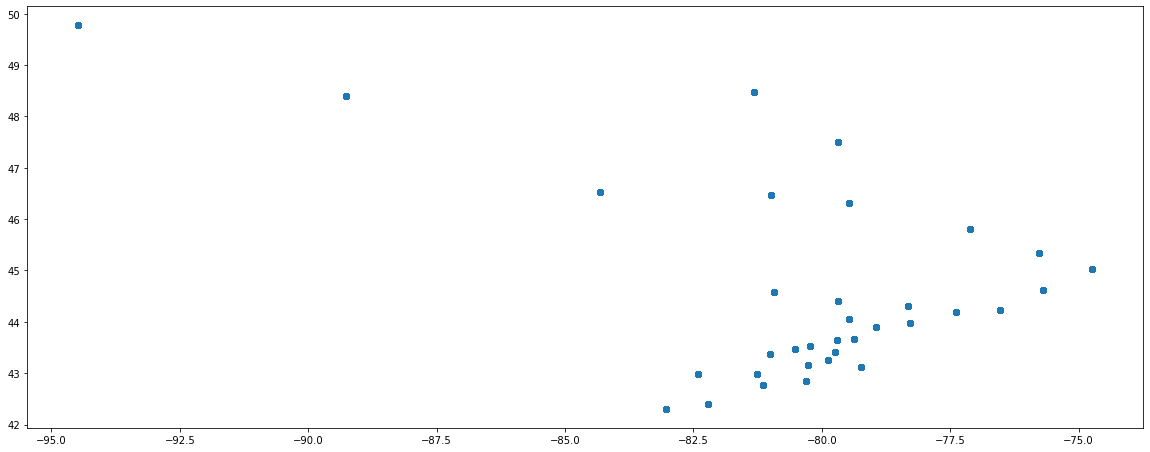

In [90]:
pos_geo["geometry"].plot()

Next step! Try out geoplot to make nice plots